In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def amplitude_fn(k0,k1,x):
    return (np.cos(x+np.pi/4)**k0)*(np.sin(x+np.pi/4)**k1)

def get_amp_max(k0,k1):
    x_max_k0_k1 = 0.5*np.arcsin((k1-k0)/(k0+k1))
    amp_max = amplitude_fn(k0,k1,x_max_k0_k1)
    return amp_max

def norm_amplitude_fn(k0,k1,x):
    amp_max = get_amp_max(k0,k1)
    return amplitude_fn(k0,k1,x)/amp_max

def expo(k0,k1,x):
    return np.exp(-x*(k0-k1))/get_amp_max(k0,k1)

In [3]:
x = np.arange(-np.pi/4, np.pi/4, 0.01)

In [4]:
k0, k1 = 50, 0
values_1 = norm_amplitude_fn(k0,k1,x)
exp_values_1 = expo(k0,k1,x)

k0, k1 = 30, 20
values_2 = norm_amplitude_fn(k0,k1,x)
exp_values_2 = expo(k0,k1,x)

k0, k1 = 5, 45
values_3 = norm_amplitude_fn(k0,k1,x)
exp_values_3 = expo(k0,k1,x)

(0.0, 1.1)

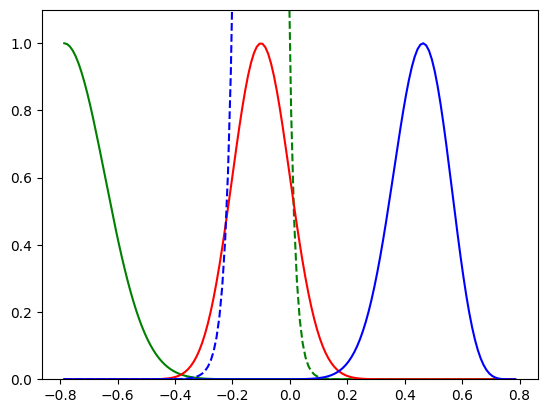

In [5]:
plt.plot(x,values_1,'g')
plt.plot(x,exp_values_1,'g--')

plt.plot(x,values_2,'r')
plt.plot(x,exp_values_2,'r--')

plt.plot(x,values_3,'b')
plt.plot(x,exp_values_3,'b--')

plt.ylim(0,1.1)

In [6]:
k0, k1 = 500, 0
values_1 = norm_amplitude_fn(k0,k1,x)
exp_values_1 = expo(k0,k1,x)

k0, k1 = 300, 200
values_2 = norm_amplitude_fn(k0,k1,x)
exp_values_2 = expo(k0,k1,x)

k0, k1 = 50, 450
values_3 = norm_amplitude_fn(k0,k1,x)
exp_values_3 = expo(k0,k1,x)

(0.0, 1.1)

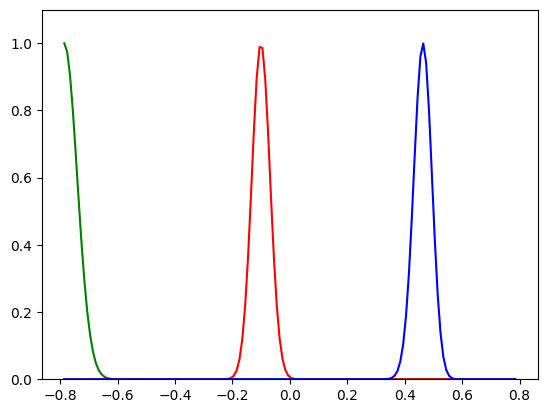

In [7]:
plt.plot(x,values_1,'g')

plt.plot(x,values_2,'r')

plt.plot(x,values_3,'b')

plt.ylim(0,1.1)

In [169]:
from qiskit import *
from qiskit.quantum_info import SparsePauliOp
from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit.opflow import PauliTrotterEvolution
from qiskit.opflow.evolutions import Suzuki
from qiskit.circuit import Parameter
from qiskit.primitives import Sampler
from qiskit import Aer

In [62]:
def compute_U_trot(H, time, trotter_steps, order=1):
    """
    Apply the Suzuki-Trotter approximation to the Hamiltonian H to 
    compute a trotterized unitary time evolution operator.

    """

    U_trot = Suzuki(trotter_steps, order=order).convert(time * H)
    return U_trot

In [63]:
def convert_U_trot_to_qc(U_trot):
    """
    Convert the U_trot ComposedOp object returned by compute_U_trot() to a bare quantum circuit.
    """

    qc_trot = PauliTrotterEvolution().convert(U_trot)
    return (
        qc_trot.to_circuit().decompose().decompose()
    )  # add decompose methods so gates are not abstracted unitary blocks

In [68]:
H = PauliSumOp(SparsePauliOp(["ZY",],[1]))

time_param = Parameter("t")
trotter_steps = 1

# Compute unitary time operator
U_trot_params = compute_U_trot(H, time_param, int(trotter_steps))

# Convert to trotterized unitary to circuit
qc_trot = convert_U_trot_to_qc(U_trot_params)

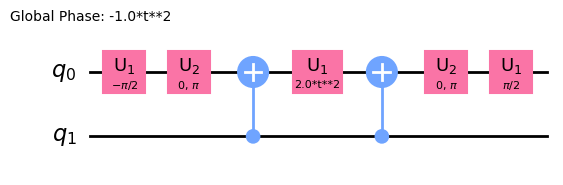

In [69]:
qc_trot.draw('mpl')

In [178]:
qr = QuantumRegister(2)
cr = ClassicalRegister(1, name="ancilla_reg")

qc = QuantumCircuit(qr,cr)

t = 5
for i in range(t):
    qc.h(1)
    qc.append(qc_trot, [0,1])
    qc.measure([1],cr)
    
    if i != t-1:
        with qc.if_test((cr,1)):
            qc.x(0)
        qc.reset(1)
    
qc = qc.decompose()

qc.draw(fold=115)

global phase: -5.0*t**2
             ┌──────────┐┌─────────┐┌───┐┌──────────────┐┌───┐┌─────────┐┌─────────┐┌──────────┐┌──────────┐»
      q77_0: ┤ U1(-π/2) ├┤ U2(0,π) ├┤ X ├┤ U1(2.0*t**2) ├┤ X ├┤ U2(0,π) ├┤ U1(π/2) ├┤0         ├┤ U1(-π/2) ├»
             ├─────────┬┘└─────────┘└─┬─┘└──────────────┘└─┬─┘└───┬─┬───┘└─────────┘│          │├─────────┬┘»
      q77_1: ┤ U2(0,π) ├──────────────■────────────────────■──────┤M├────────|0>────┤  If_else ├┤ U2(0,π) ├─»
             └─────────┘                                          └╥┘               │          │└─────────┘ »
ancilla_reg: ══════════════════════════════════════════════════════╩════════════════╡0         ╞════════════»
                                                                                    └──────────┘            »
«             ┌─────────┐┌───┐┌──────────────┐┌───┐┌─────────┐┌─────────┐┌──────────┐┌──────────┐┌─────────┐┌───┐»
«      q77_0: ┤ U2(0,π) ├┤ X ├┤ U1(2.0*t**2) ├┤ X ├┤ U2(0,π) ├┤ U1(π/2) ├┤0         ├┤ U1(-π/2) ├┤ U2(0,π) ├┤ X ├»
«             └─────────┘└─┬─┘└──────────────┘└─┬─┘└───┬─┬───┘└─────────┘│          │├─────────┬┘└─────────┘└─┬─┘»
«      q77_1: ─────────────■────────────────────■──────┤M├────────|0>────┤  If_else ├┤ U2(0,π) ├──────────────■──»
«                                                      └╥┘               │          │└─────────┘                 »
«ancilla_reg: ══════════════════════════════════════════╩════════════════╡0         ╞════════════════════════════»
«                                                                        └──────────┘                            »
«             ┌──────────────┐┌───┐┌─────────┐┌─────────┐┌──────────┐┌──────────┐┌─────────┐┌───┐┌──────────────┐»
«      q77_0: ┤ U1(2.0*t**2) ├┤ X ├┤ U2(0,π) ├┤ U1(π/2) ├┤0         ├┤ U1(-π/2) ├┤ U2(0,π) ├┤ X ├┤ U1(2.0*t**2) ├»
«             └──────────────┘└─┬─┘└───┬─┬───┘└─────────┘│          │├─────────┬┘└─────────┘└─┬─┘└──────────────┘»
«      q77_1: ──────────────────■──────┤M├────────|0>────┤  If_else ├┤ U2(0,π) ├──────────────■──────────────────»
«                                      └╥┘               │          │└─────────┘                                 »
«ancilla_reg: ══════════════════════════╩════════════════╡0         ╞════════════════════════════════════════════»
«                                                        └──────────┘                                            »
«             ┌───┐┌─────────┐┌─────────┐┌──────────┐┌──────────┐┌─────────┐┌───┐┌──────────────┐┌───┐┌─────────┐»
«      q77_0: ┤ X ├┤ U2(0,π) ├┤ U1(π/2) ├┤0         ├┤ U1(-π/2) ├┤ U2(0,π) ├┤ X ├┤ U1(2.0*t**2) ├┤ X ├┤ U2(0,π) ├»
«             └─┬─┘└───┬─┬───┘└─────────┘│          │├─────────┬┘└─────────┘└─┬─┘└──────────────┘└─┬─┘└───┬─┬───┘»
«      q77_1: ──■──────┤M├────────|0>────┤  If_else ├┤ U2(0,π) ├──────────────■────────────────────■──────┤M├────»
«                      └╥┘               │          │└─────────┘                                          └╥┘    »
«ancilla_reg: ══════════╩════════════════╡0         ╞══════════════════════════════════════════════════════╩═════»
«                                        └──────────┘                                                            »
«             ┌─────────┐
«      q77_0: ┤ U1(π/2) ├
«             └─────────┘
«      q77_1: ───────────
«                        
«ancilla_reg: ═══════════
«

In [179]:
temp_qc = qc.assign_parameters([1])

backend_sim = Aer.get_backend("aer_simulator")
job = backend_sim.run(temp_qc)
result = job.result()
counts = result.get_counts()

print(counts)

# sampler = Sampler()
# job = sampler.run(circuits = [temp_qc], shots=1)

# print(job.result())    

{'1': 518, '0': 506}


In [10]:
# import pennylane as qml
# import pennylane.numpy as np

In [11]:
# h1_obs = []
# h1_coeffs = []

# h2_obs = []
# h2_coeffs = []

# L = 5
# lamb = 1
# epsilon = 0.12
# for i in range(L):
#     h1_obs.append(qml.PauliX(i)@qml.PauliY(L))
#     h1_coeffs.append(lamb*epsilon*0.5)
    
# for i in range(L-1):
#     h2_obs.append(qml.PauliZ(i)@qml.PauliZ(i+1)@qml.PauliY(L))
#     h2_coeffs.append(lamb*epsilon)
    
# H1 = qml.Hamiltonian(h1_coeffs, h1_obs)
# H2 = qml.Hamiltonian(h2_coeffs, h2_obs)

# print(H1)
# print()
# print(H2)

In [12]:
# phi = np.random.random((L,3))

# def Uc():
#     for i in range(L):
#         qml.RZ(phi[i,0],i)
#         qml.RY(phi[i,1],i)
#         qml.RX(phi[i,2],i)

# def circuit(t):
#     qml.Hadamard(L)
#     qml.ApproxTimeEvolution(H1, t, 1)
#     qml.ApproxTimeEvolution(H2, t, 1)
#     qml.ApproxTimeEvolution(H1, t, 1)

In [13]:
# H = qml.Hamiltonian([1.0], [qml.PauliZ(0)@qml.PauliY(1)])
# print(H)

In [14]:
# dev = qml.device('default.qubit', wires=2, shots = 1)

# @qml.qnode(dev)
# def circuit(t):
#     qml.Hadamard(1)
#     qml.ApproxTimeEvolution(H, t, 1)
#     return qml.sample(wires=[1])

In [15]:
# print(qml.draw(circuit, expansion_strategy='device')(3))

In [16]:
# counts = circuit(3)
# print(counts)
# print(np.sum(counts == 0))
# print(np.sum(counts == 1))

In [17]:
# Eth = 0

In [18]:
# k0, k1 = 5, 20
# amp_max = get_amp_max(k0,k1)
# amp_max

In [19]:
# dev = qml.device('default.qubit', wires=2, shots = 1)

# k = [0,0]

# for t in range(1, 101):

#     @qml.qnode(dev)
#     def circuit(t):
#         qml.Hadamard(1)
#         qml.ApproxTimeEvolution(H, t, 1)
#         return qml.sample(wires=[1])
    
#     circuit()
    
    